In [2]:
import pandas as pd
import numpy as np

import black_box as bb

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import graphviz
from yellowbrick.features import Rank2D, Rank1D
import matplotlib.pyplot as plt

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp

import lime
import lime.lime_tabular

import shap

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (15,10)
shap.initjs()

In [4]:
def explore_feature_importances(feature_importances, feature_names):
    plt.rcParams["figure.figsize"] = (15,10)
    fi = sorted(zip(feature_importances, feature_names), reverse=True)
    for s,c in fi:
        print(f'{s:15.3f} {c}')
    plt.bar(range(len(fi)), [f[0] for f in fi])
    plt.title('Feature Importances')
    plt.show()
    
def explore_model(model, X, y, fi = None):
    plt.scatter(y, model.predict(X))
    plt.title('True vs Predicted')
    plt.show()
    print('Score: ', model.score(X,y))
    plt.rcParams["figure.figsize"] = (15,10)
    if fi is None:
        fi = model.feature_importances_
    explore_feature_importances(fi, X.columns)

# Data

In [5]:
df = pd.read_csv('data/kc_house_data.csv', parse_dates=['date'])
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [7]:
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [8]:
y = df['price']
X = df.drop(['price', 'id', 'date', 'zipcode'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

X_train = X_train.reset_index()
X_val = X_val.reset_index()

# Correlations of features with price

                  price
sqft_living    0.702035
grade          0.667434
sqft_above     0.605567
sqft_living15  0.585379
bathrooms      0.525138
view           0.397293
sqft_basement  0.323816
bedrooms       0.308350
lat            0.307003
waterfront     0.266369
floors         0.256794
yr_renovated   0.126434
sqft_lot       0.089661
sqft_lot15     0.082447
yr_built       0.054012
condition      0.036362
long           0.021626
zipcode       -0.053203


<BarContainer object of 18 artists>

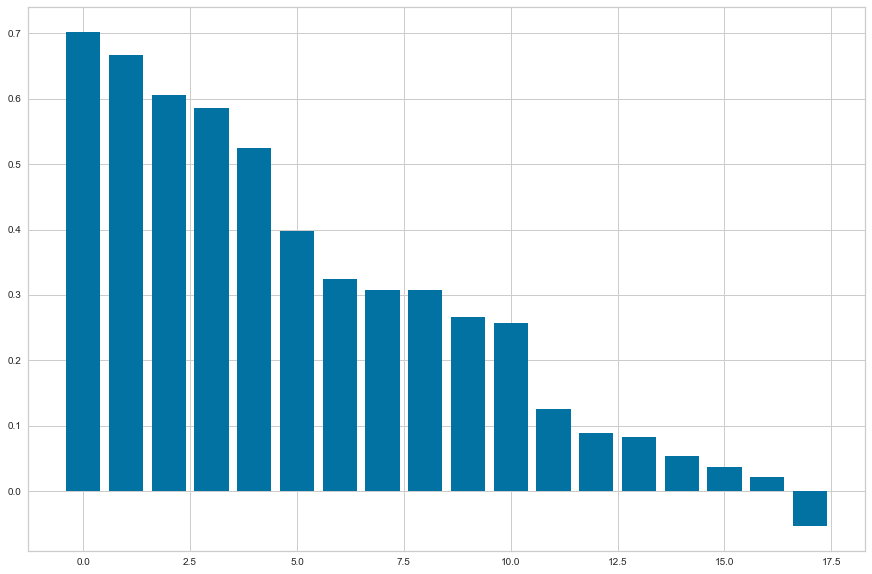

In [9]:
corr_df = pd.DataFrame(df.drop(['id'],axis=1).corr()['price']).iloc[1:].sort_values('price',ascending=False)
print(corr_df)
plt.bar(range(len(corr_df)), corr_df['price'])


# Linear models

Coefficients directly identify important features.

Work great until you have:
    
* too many dimensions
* use feature engineering / reduction
* need accuracy/performance

![right,60%](img/simple_linear.png)

0.69561


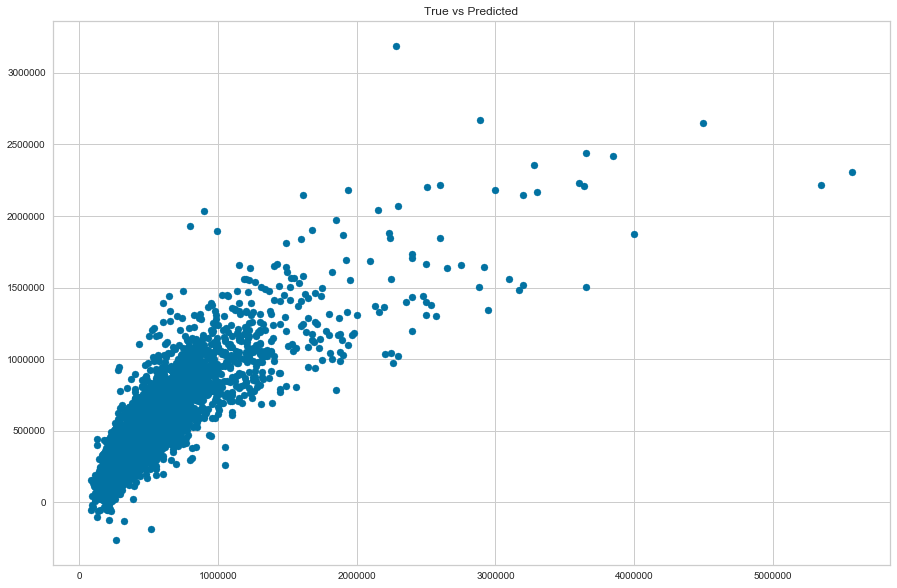

Score:  0.6956132226546315
     568599.162 waterfront
     556102.040 lat
      95941.882 grade
      50448.211 view
      45577.237 bathrooms
      28898.824 condition
         90.172 sqft_above
         87.346 sqft_living
         57.304 sqft_basement
         26.869 sqft_living15
         21.825 yr_renovated
          1.236 index
          0.085 sqft_lot
         -0.326 sqft_lot15
       -207.455 floors
      -2583.994 yr_built
     -32701.295 bedrooms
     -97861.302 long


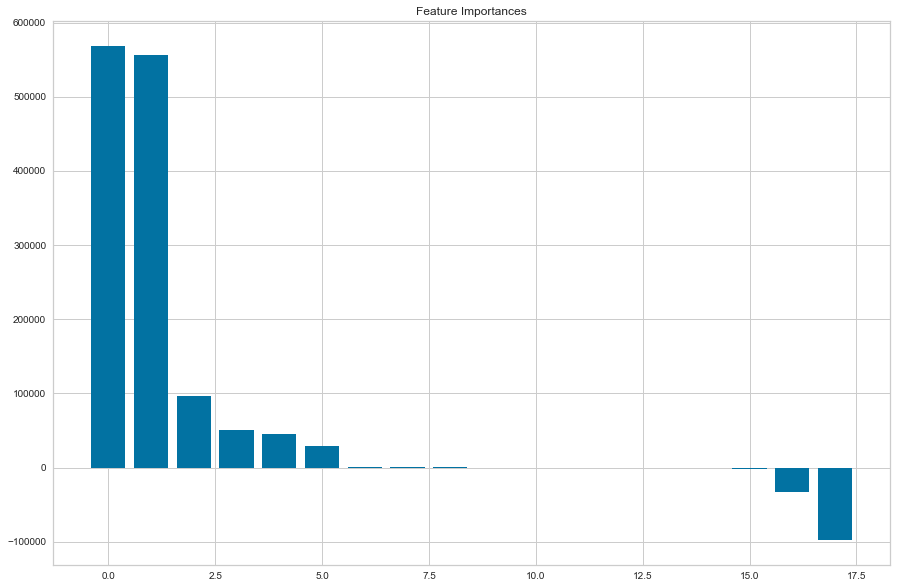

In [10]:
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)

print(f'{model.score(X_val, y_val):.5f}')
explore_model(model, X_val, y_val, model.coef_)


# Decision trees

Directly inspect the decisions of internal nodes.
Intuitive and visual representation.

Work great until you

* have too many decision points
* decide to use ensembles / boosting

![right,50%](img/simple_dt.png)

# Try a decision tree

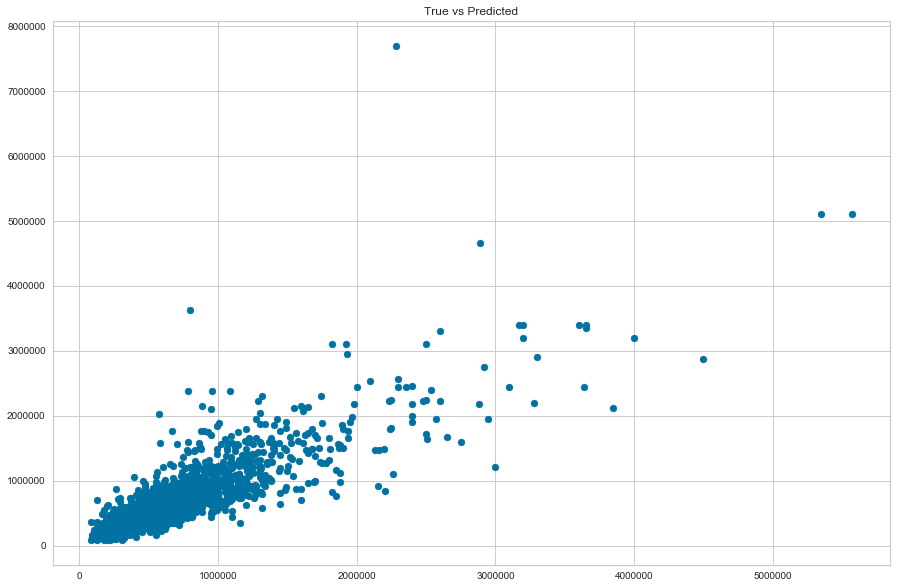

Score:  0.7249729174201427
          0.360 grade
          0.241 sqft_living
          0.158 lat
          0.063 long
          0.032 sqft_living15
          0.032 waterfront
          0.030 yr_built
          0.016 sqft_lot
          0.015 sqft_above
          0.010 sqft_lot15
          0.010 bathrooms
          0.010 index
          0.009 view
          0.005 sqft_basement
          0.003 condition
          0.003 bedrooms
          0.002 yr_renovated
          0.001 floors


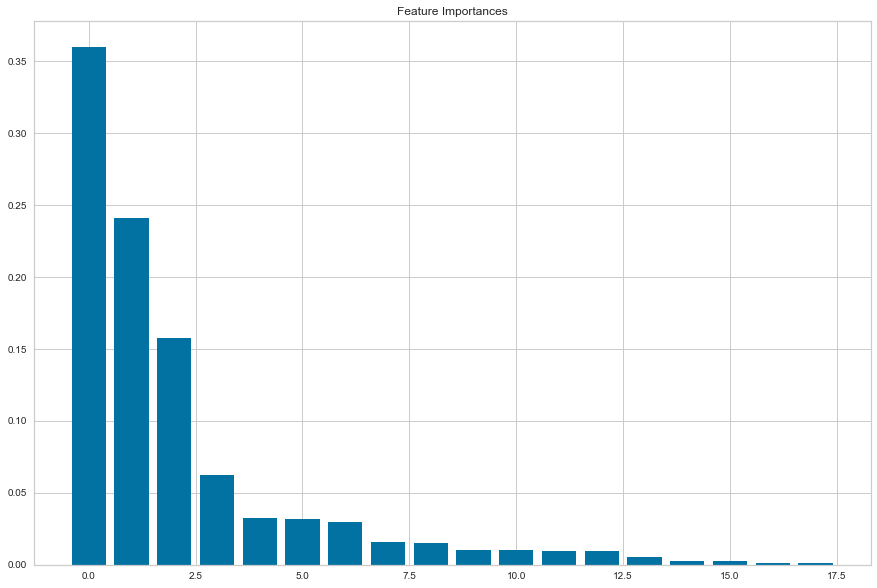

In [11]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
explore_model(model, X_val, y_val)

# We can view the tree ... in theory

In [12]:
# sklearn trees have an export function ... but this tree is too big to view
# export_graphviz(model,out_file='full_tree.dot', feature_names=X_train.columns)

model.tree_.max_depth

37

# Lets try a simpler tree

In [13]:
model = DecisionTreeRegressor(max_depth=4)
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

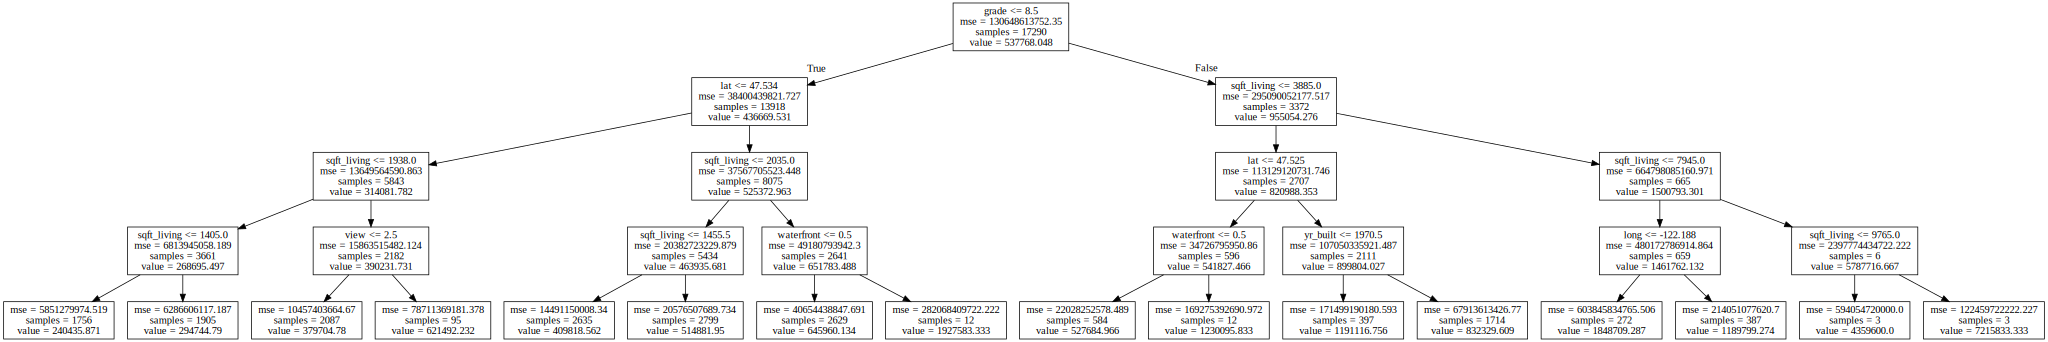

In [14]:
export_graphviz(model,out_file='tree.dot', feature_names=X_train.columns)
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

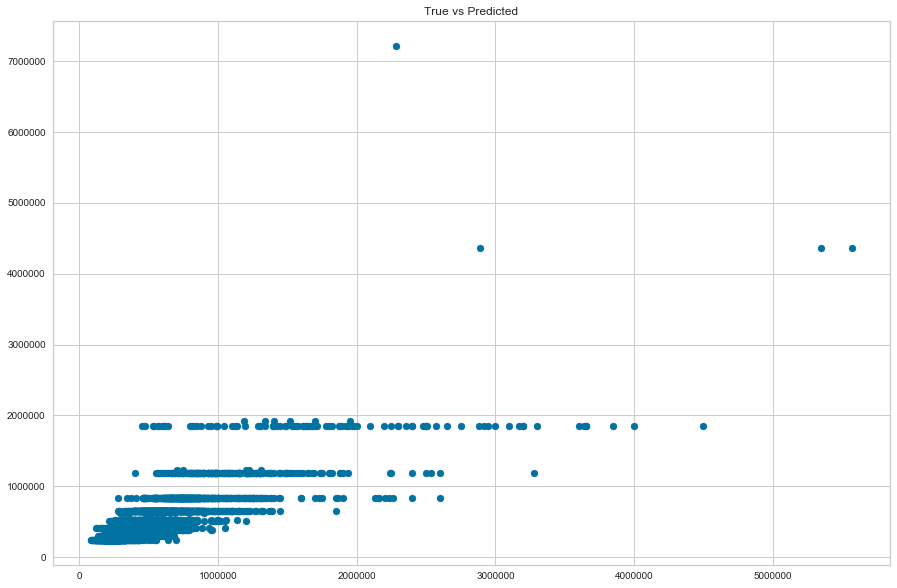

Score:  0.610316682917837
          0.470 grade
          0.303 sqft_living
          0.136 lat
          0.045 long
          0.027 yr_built
          0.016 waterfront
          0.003 view
          0.000 yr_renovated
          0.000 sqft_lot15
          0.000 sqft_lot
          0.000 sqft_living15
          0.000 sqft_basement
          0.000 sqft_above
          0.000 index
          0.000 floors
          0.000 condition
          0.000 bedrooms
          0.000 bathrooms


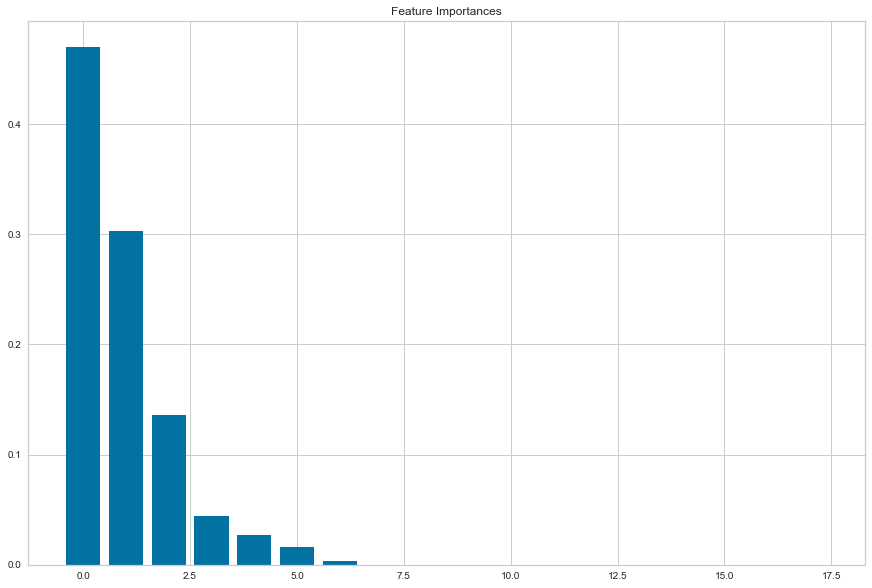

In [15]:
explore_model(model, X_val, y_val)


# Feature importance 

* coefficients 
* information gain metric
* num of times feature used in a split
* permutations


# What if your model doesn't support feature importance? Feature permutation

- Consider each feature in turn.
- Shuffle values in column.
- Rank features based on the performance drop.

Local version: Leave One Covariate Out (LOCO)


## Train a black box model

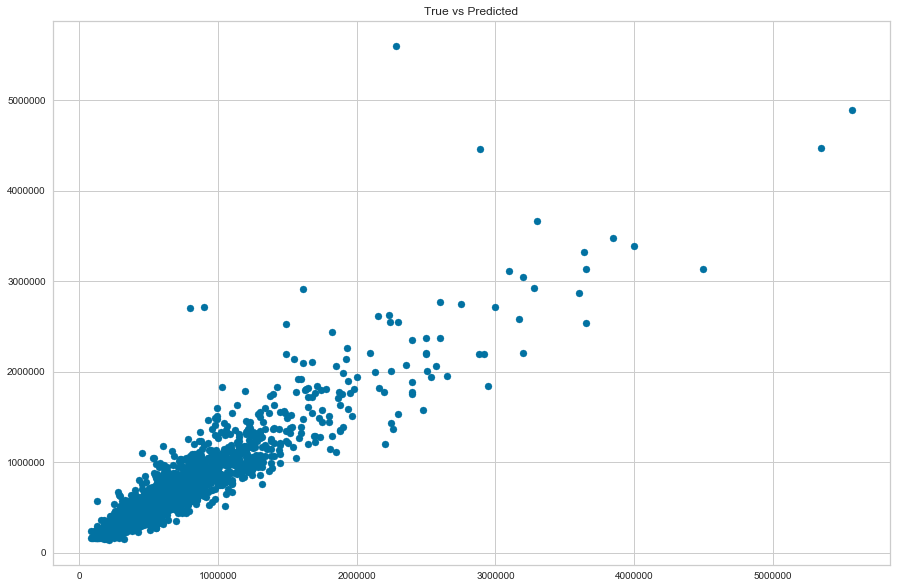

Score:  0.8625664053396804
          0.210 lat
          0.136 long
          0.099 sqft_living
          0.089 grade
          0.070 sqft_above
          0.068 sqft_living15
          0.057 yr_built
          0.054 sqft_lot
          0.047 sqft_basement
          0.030 bathrooms
          0.025 sqft_lot15
          0.024 view
          0.020 waterfront
          0.020 condition
          0.015 yr_renovated
          0.015 bedrooms
          0.014 index
          0.007 floors


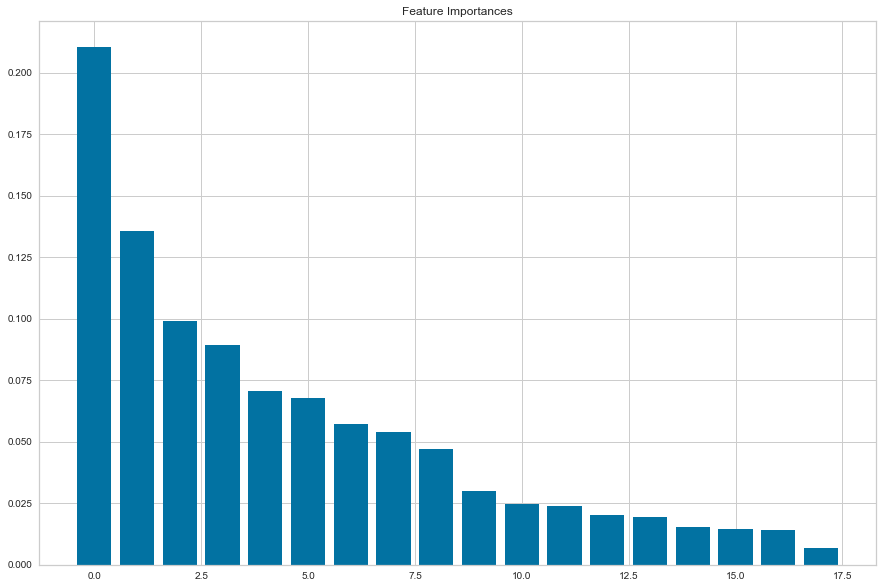

In [16]:
model = bb.create_black_box()
model.fit(X_train,y_train)
explore_model(model,X_val, y_val)

# Try permutation importances (w/ eli5).

          0.288 lat
          0.196 grade
          0.178 sqft_living
          0.114 long
          0.035 sqft_living15
          0.030 waterfront
          0.026 yr_built
          0.025 sqft_lot
          0.014 sqft_above
          0.013 view
          0.007 condition
          0.003 sqft_basement
          0.002 yr_renovated
          0.001 floors
         -0.000 sqft_lot15
         -0.000 bedrooms
         -0.001 index
         -0.014 bathrooms


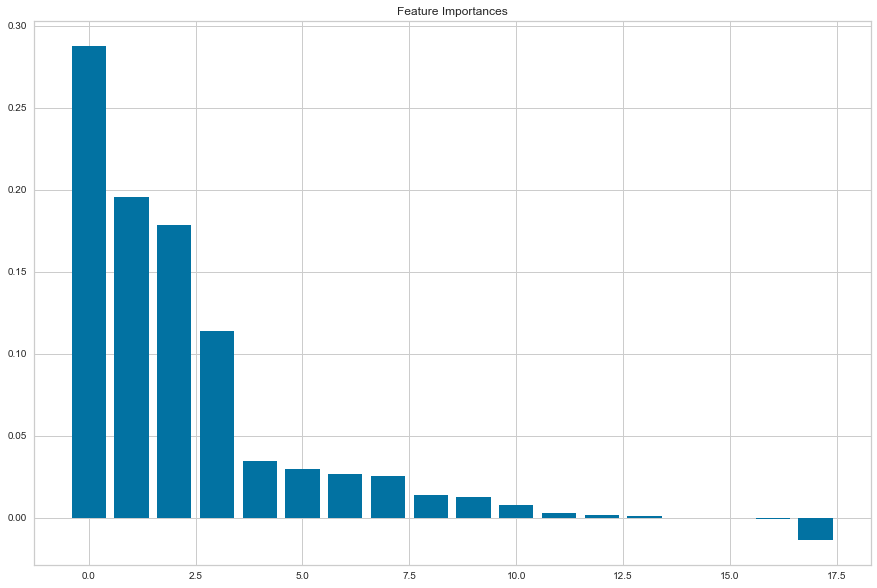

In [17]:
perm = PermutationImportance(model).fit(X_val, y_val)
explore_feature_importances(perm.feature_importances_, X_val.columns)

# What about on the training data?

          0.318 lat
          0.236 grade
          0.212 sqft_living
          0.124 long
          0.041 sqft_lot
          0.040 sqft_living15
          0.033 yr_built
          0.031 waterfront
          0.022 sqft_above
          0.016 view
          0.009 condition
          0.006 bathrooms
          0.006 sqft_basement
          0.004 sqft_lot15
          0.002 yr_renovated
          0.001 bedrooms
          0.001 index
          0.000 floors


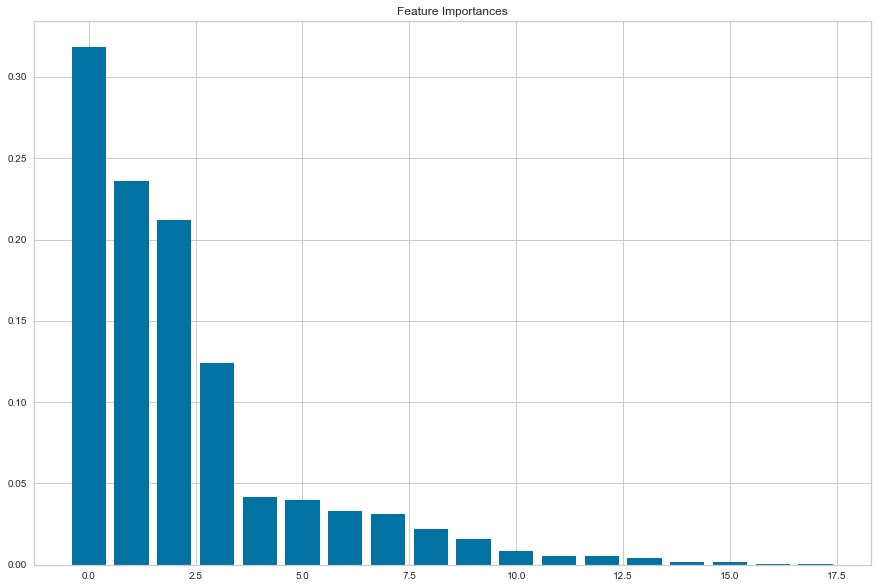

In [18]:
perm = PermutationImportance(model).fit(X_train, y_train)
explore_feature_importances(perm.feature_importances_, X_train.columns)

# Lat is important but not strongly corrolated. Why?

# Partial Dependence Plot (pdpbox)

- Choose 1 feature
- Vary its value while keeping the others fixed
- Observe effect on prediction and calculate the mean

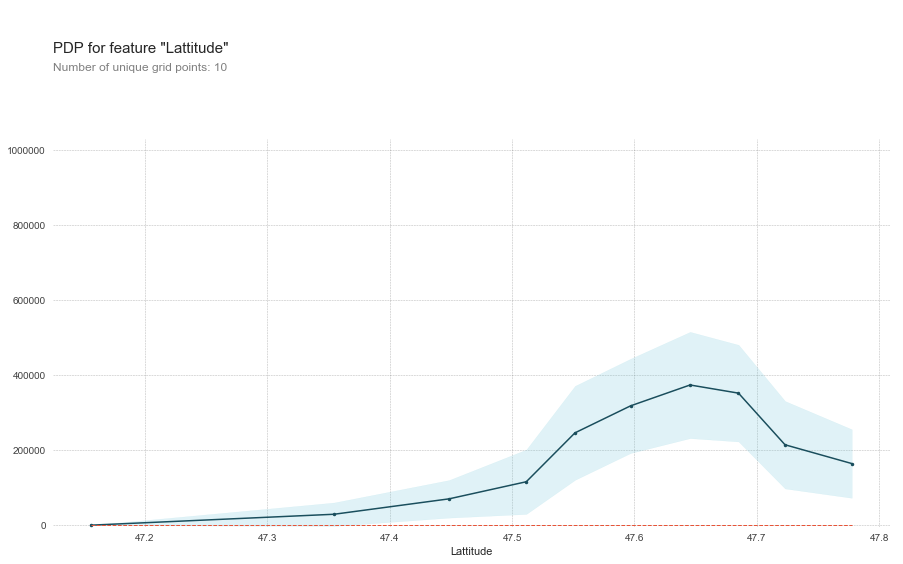

In [19]:
pdp_lat = pdp.pdp_isolate(model=model, dataset=X_val, model_features=X_train.columns, feature='lat')
fig, axes = pdp.pdp_plot(pdp_lat, 'Lattitude')

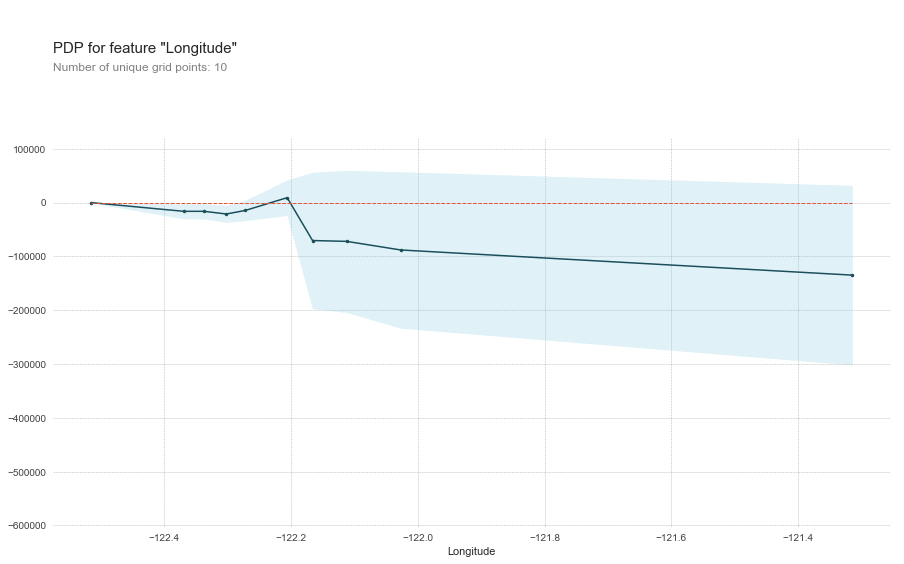

In [20]:
pdp_long = pdp.pdp_isolate(model=model, dataset=X_val, model_features=X_train.columns, feature='long')
fig, axes = pdp.pdp_plot(pdp_long, 'Longitude')

# King County
## Seattle geo coords: 47.6062° N, 122.3321° W
![title](img/king_county_map.png)

# What about Lat and Long together?
## Actually, pdpbox can do two features at once.

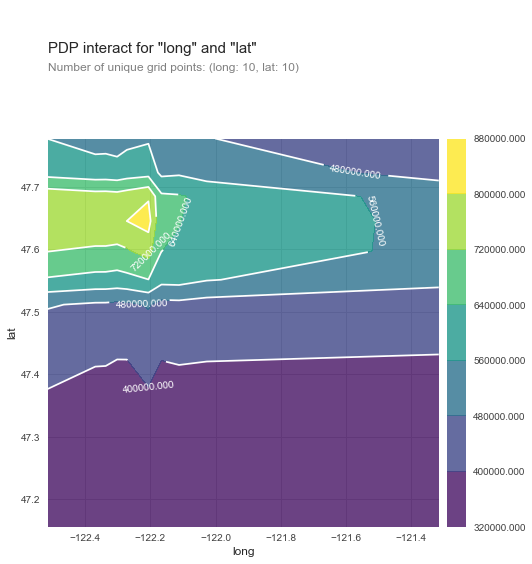

In [21]:
inter_rf = pdp.pdp_interact(
    model=model, dataset=X_val, model_features=X_train.columns, 
    features=['long', 'lat']
)

fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['long', 'lat'], plot_type='contour', plot_pdp=False
)


# Individual Conditional Expectation (ICE) - "Local" effects of Lat

## Similar to PDP where you focus on one sample.


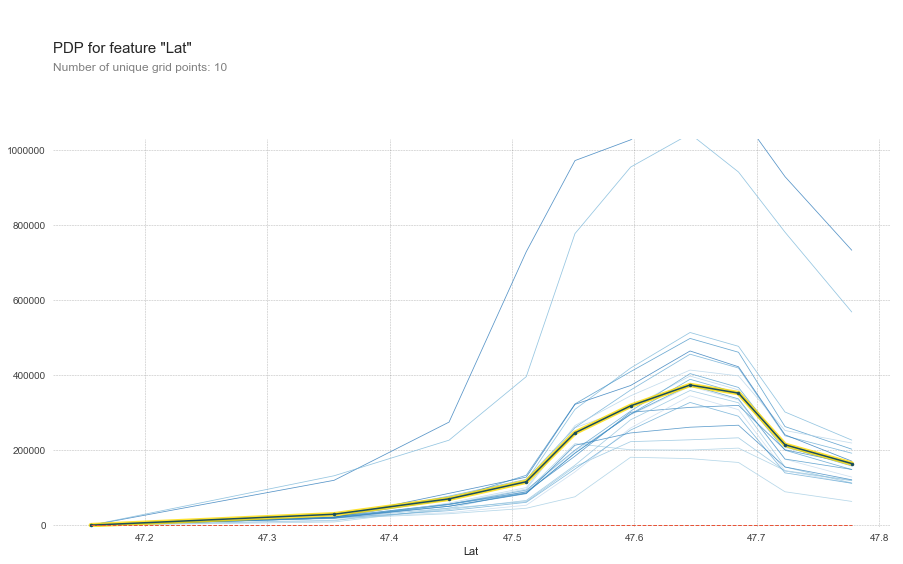

In [22]:
fig, axes = pdp.pdp_plot(pdp_lat, 'Lat', plot_lines=True, frac_to_plot=20)

# Surrogate Models
## Train an _iterpretable_ model on the predictions of a complex model

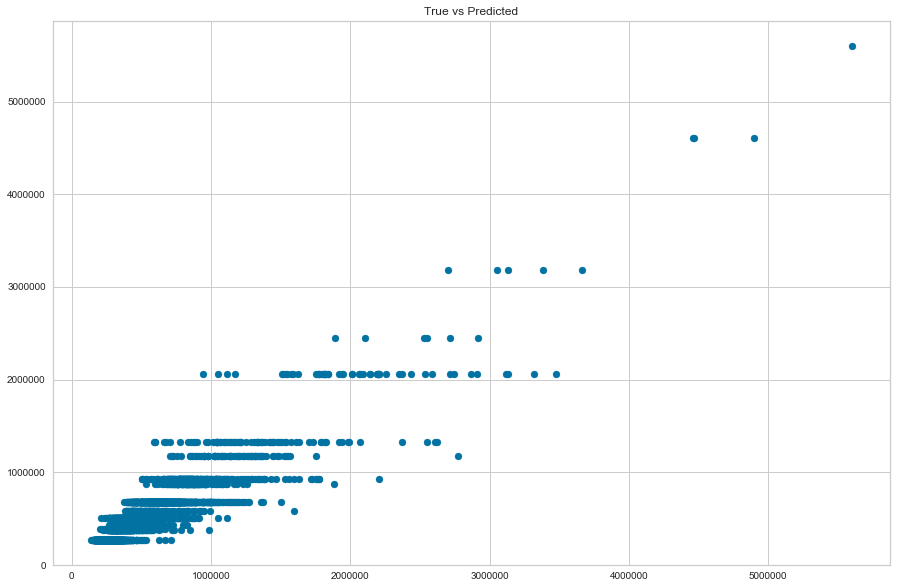

Score:  0.8243676832367399
          0.481 grade
          0.330 sqft_living
          0.123 lat
          0.065 long
          0.002 sqft_above
          0.000 yr_renovated
          0.000 yr_built
          0.000 waterfront
          0.000 view
          0.000 sqft_lot15
          0.000 sqft_lot
          0.000 sqft_living15
          0.000 sqft_basement
          0.000 index
          0.000 floors
          0.000 condition
          0.000 bedrooms
          0.000 bathrooms


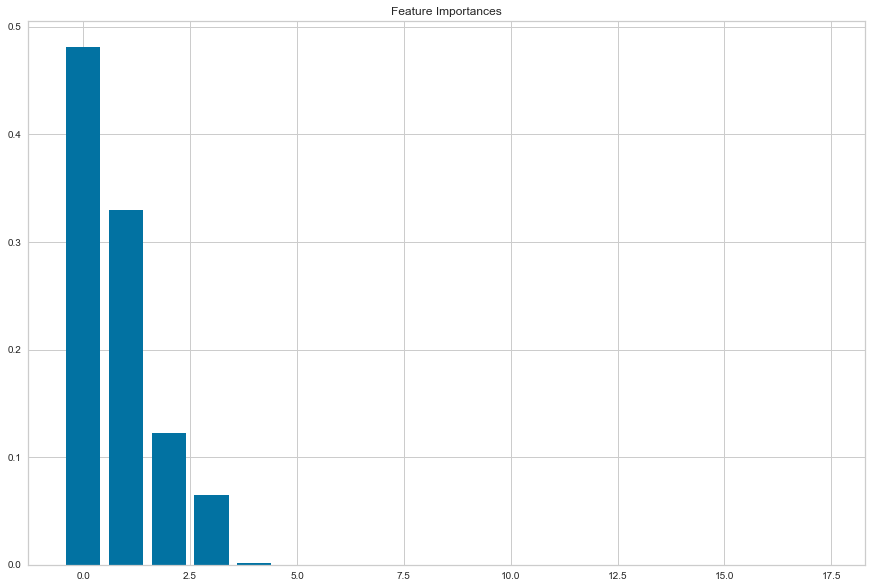

In [23]:
preds = model.predict(X_val)
surrogate = DecisionTreeRegressor(max_depth=4)
surrogate.fit(X_val, preds)
surrogate_preds = surrogate.predict(X_val)
explore_model(surrogate, X_val, preds)

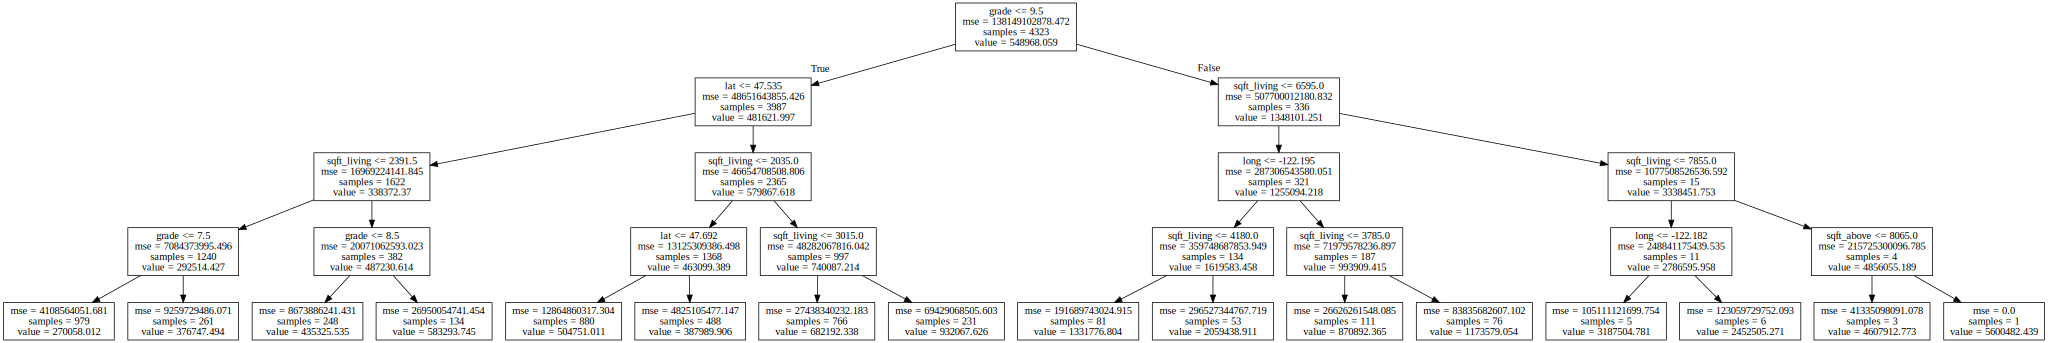

In [24]:
export_graphviz(surrogate,out_file='surrogate.dot', feature_names=X_val.columns)
with open("surrogate.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

# Local Interpretable Model-Agnostic Explanations (LIME)

Given a trained model and a particular sample

- generate random samples near the given sample
- weight generated samples based on proximity 
- fit an explainable model to the generated data and predictions



# Lat Lon Example

![inline](img/latlon.png)


In [25]:
X_val[(X_val.bedrooms == 3.0) & (X_val.bathrooms == 2.5)].sort_values(['grade', 'sqft_living'])[['bedrooms', 'bathrooms', 'grade', 'sqft_living']]

,bedrooms,bathrooms,grade,sqft_living
444,3,2.5,6,1970
3383,3,2.5,7,1070
1550,3,2.5,7,1090
2219,3,2.5,7,1212
4278,3,2.5,7,1230
1769,3,2.5,7,1270
1179,3,2.5,7,1322
3536,3,2.5,7,1340
1188,3,2.5,7,1365
876,3,2.5,7,1370


In [26]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_val.values, 
                                                       feature_names=X_val.columns, 
                                                       class_names=['price'], 
                                                       verbose=True,
                                                       mode='regression')

In [27]:
i = 444
print(i)
print(X_val.iloc[i])
print('True value',y_val.iloc[i])
print()

exp = lime_explainer.explain_instance(X_val.values[i], model.predict, num_features=5)
exp.show_in_notebook(show_table=True)

444
index            4618.0000
bedrooms            3.0000
bathrooms           2.5000
sqft_living      1970.0000
sqft_lot         4120.0000
floors              1.5000
waterfront          0.0000
view                0.0000
condition           3.0000
grade               6.0000
sqft_above       1230.0000
sqft_basement     740.0000
yr_built         1927.0000
yr_renovated        0.0000
lat                47.5328
long             -122.3460
sqft_living15    1470.0000
sqft_lot15       4080.0000
Name: 444, dtype: float64
True value 291700.0

Intercept 925750.088066291
Prediction_local [458172.61090999]
Right: 336068.7105261741


# Shapley values

Game theoretic approach to assigning attribution to features.

The Shapley value is the average expected marginal contribution of one player after all possible combinations have been considered. 

# Shapley (cont.)

Proponents claim: 

* locally accuracy
* missingness
* consistency

# Shap

Calculate performance of all possible subset of features with and without the feature.

Exponential in number of features - estimation algorithms and tricks for trees.

Can be used to study feature interaction.

In [28]:
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X_val)

print(i)
for s,f in sorted(zip(shap_values[i,:],X_val.columns), reverse=True):
    print(f'{s:15.2f}  {f:13s} {X_val.iloc[i][f]:10.2f}')
    
shap.force_plot(shap_explainer.expected_value, shap_values[i,:], X_val.iloc[i,:])

444
       32223.99  yr_built         1927.00
       13902.03  long             -122.35
        1192.82  bedrooms            3.00
         468.64  floors              1.50
        -122.23  index            4618.00
        -267.81  bathrooms           2.50
       -1396.57  yr_renovated        0.00
       -2016.78  waterfront          0.00
       -2163.89  sqft_basement     740.00
       -2417.49  sqft_lot15       4080.00
       -5963.88  sqft_lot         4120.00
       -7268.25  view                0.00
       -9359.24  condition           3.00
      -14517.17  sqft_above       1230.00
      -24437.37  lat                47.53
      -33685.27  sqft_living      1970.00
      -37872.91  sqft_living15    1470.00
     -107997.95  grade               6.00


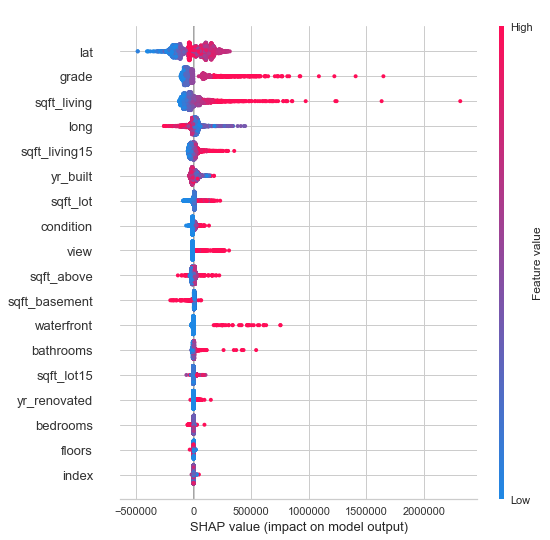

In [29]:
shap.summary_plot(shap_values, X_val)

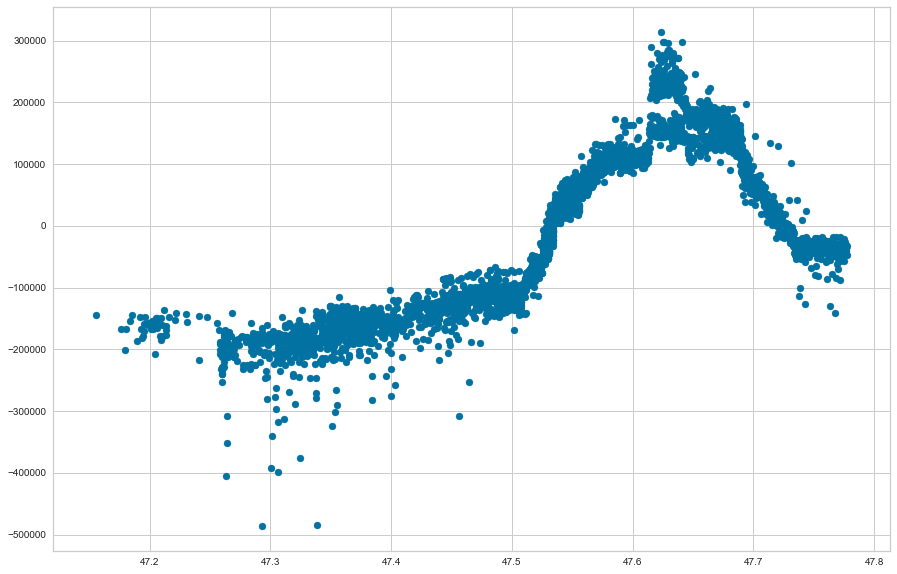

In [30]:
feature = 'lat'
col_index = list(X_val.columns).index(feature)
_ = plt.scatter(X_val[feature], shap_values[:,col_index])

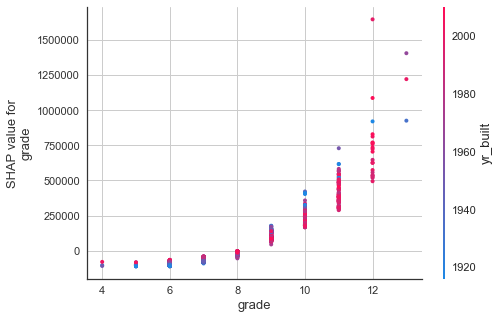

In [31]:
shap.dependence_plot("grade", shap_values, X_val)

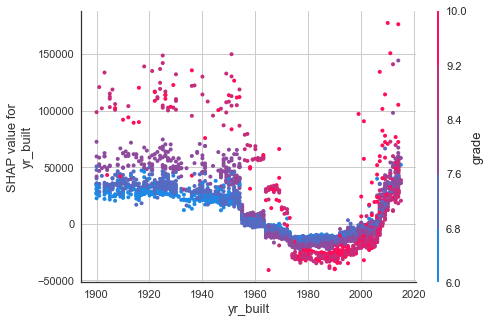

In [32]:
shap.dependence_plot("yr_built", shap_values, X_val)